In [1]:
from CHEM274.importer_snippets import load_experiment
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('JGW-PPT')

# Impedance fitting package: https://impedancepy.readthedocs.io/en/latest/index.html
from impedance.models.circuits import CustomCircuit
from impedance.preprocessing import ignoreBelowX
from impedance.visualization import plot_nyquist, plot_residuals
from impedance.validation import linKK, eval_linKK

In [2]:
EIS = load_experiment(csv_dirname=r"C:\Users\jgage\Documents\GitHub\CHEM274\data\EIS_Fc_Gc_MeAc_P-07-03") # Warning - this function may take ~5 minutes to run if loading .xlsx.
EIS.data

,f,Yre,Yim,Zre,Zim
0,6250.000000,0.002472,-0.000025,404.548679,4.099915
1,3125.000000,0.002516,0.000028,397.452915,-4.481686
2,1562.500000,0.002482,0.000108,402.088049,-17.531893
3,781.250000,0.002426,0.000163,410.371495,-27.655342
4,390.625000,0.002331,0.000219,425.174818,-40.004142
5,195.312500,0.002224,0.000298,441.645453,-59.203366
6,97.656250,0.002084,0.000374,464.938304,-83.498995
7,48.828125,0.001909,0.000452,496.044806,-117.427825
8,24.414062,0.001638,0.000509,556.656230,-173.084784
9,12.207031,0.001379,0.000571,619.052723,-256.350378


In [3]:
Zseries = EIS.data['Zre'] + 1j*EIS.data['Zim']
f, Z = EIS.data['f'].to_numpy(), Zseries.to_numpy()
n = 0
for i in Z:
    if np.real(i) < 0 or -np.imag(i) < 0:
        n += 1
print(str(n)+' improperly signed impedances have been excluded')
f, Z = ignoreBelowX(f, Z)

1 improperly signed impedances have been excluded


In [4]:
circuit = 'R1-p(R2-W1,C1)' # Randles Circuit
# initial_guess = [500, 250, 100, 5e-6]
initial_guess = [500, 500, 1000, 4e-6]

# circuit = 'R1-p(R2,C2)-p(R3,C3)' # Tsierkezos-Ritter Circuit
# initial_guess = [500, 250, 100e-6, 250, 100e-6] 

circuit = CustomCircuit(circuit, initial_guess=initial_guess)
circuit.fit(f, Z) # Comment out this line to skip regression of circuit elements
fit = circuit.predict(np.linspace(f[0], f[-1], 10000))

# Check the fit
print(circuit)
# circuit.plot(ax=ax) # Get some other fit plots


Circuit string: R1-p(R2-W1,C1)
Fit: True

Initial guesses:
     R1 = 5.00e+02 [Ohm]
     R2 = 5.00e+02 [Ohm]
     W1 = 1.00e+03 [Ohm sec^-1/2]
     C1 = 4.00e-06 [F]

Fit parameters:
     R1 = 4.00e+02  (+/- 5.35e+00) [Ohm]
     R2 = 1.08e-02  (+/- 9.04e+03) [Ohm]
     W1 = 2.28e+03  (+/- 1.56e+01) [Ohm sec^-1/2]
     C1 = 3.58e-06  (+/- 8.66e-04) [F]



In [5]:
def save_Nyq_fig(fig, analyte, electrode, solvent, notebook):
    ans = input('Save the figure?')
    if ans in ['y', 'yes', 'Yes', 'yeye', 'yeah', 'why, certainly', True]:
        fig.savefig("C:\\Users\\jgage\\Documents\GitHub\\CHEM274\\data\\figs\\Nyq_"+
            analyte + electrode + solvent + notebook+'.jpg')
        print('Saved')
    else:
        print('Not saved')

10 0.7621545931465651 7.181650177629737

Completed Lin-KK Fit
M = 12
mu = 0.47


<AxesSubplot:xlabel='$f$ [Hz]', ylabel='$\\Delta$ $(\\%)$'>

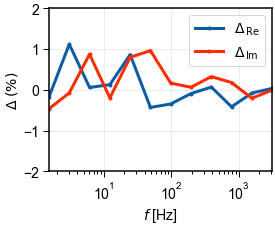

In [6]:
# Schönleber, M.; Klotz, D.; Ivers-Tiffée, E. A Method for Improving the Robustness of Linear Kramers-Kronig Validity Tests. Electrochim. Acta 2014, 131, 20–27. doi.org/10.1016/j.electacta.2014.01.034.
M, mu, Z_linKK, res_real, res_imag = linKK(f, Z, c=.5, max_M=100, fit_type='complex', add_cap=True)

print('\nCompleted Lin-KK Fit\nM = {:d}\nmu = {:.2f}'.format(M, mu))
fig, ax = plt.subplots()
fig.set_size_inches(4,3)
plot_residuals(ax, f, res_real, res_imag, y_limits=(-2,2))

# print(np.real(Z_linKK), np.imag(Z_linKK))

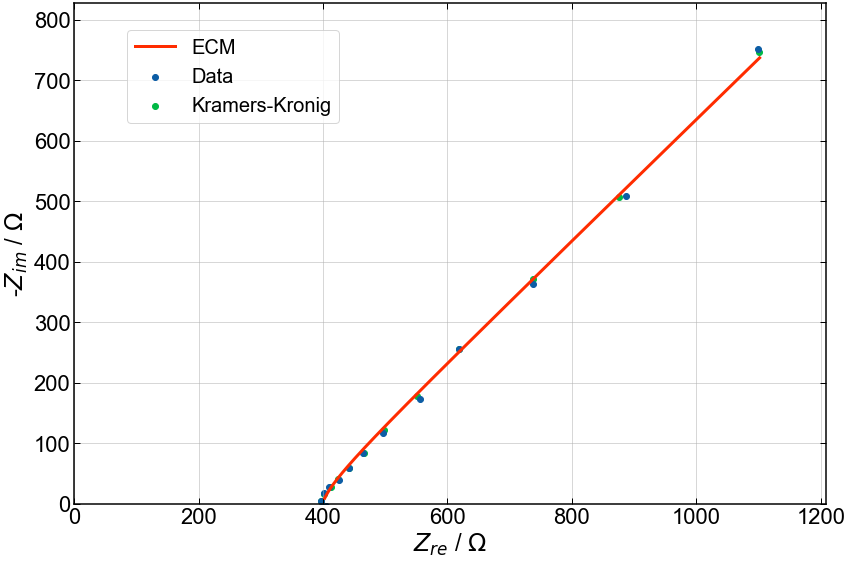

In [15]:
# Nyquist
fig = plt.figure()
ax = fig.add_subplot()

# ax.set_title('Nyquist Plot')

ax.scatter(EIS.data['Zre'], -EIS.data['Zim'], label = 'Data') # Plot experimental data
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
ax.set_xlabel('$Z_{re}$ / $\Omega$', fontsize=24)
ax.set_ylabel('-$Z_{im}$ / $\Omega$', fontsize=24)
ax.set_xlim ([0,1.1*max(EIS.data['Zre'])])
ax.set_ylim ([0,1.1*max(-EIS.data['Zim'])])
ax.plot(np.real(fit), -np.imag(fit), label='ECM', color='C1') # Plot circuit fit
ax.scatter(np.real(Z_linKK), -np.imag(Z_linKK), label='Kramers-Kronig', color='C2', zorder=0) # Plot LinKK result

# Make some good guesses about axes max, given what I know out data looks like.
xmax = EIS.data['Zre'].max()
ymax = -EIS.data['Zim'].min()
ax.set_xlim(0, xmax*1.1)
ax.set_ylim(0, ymax*1.1)

fig.tight_layout()
fig.legend(loc=(.15, .78), prop={'size': 20})

analyte = 'Fc_'
electrode = 'GC_'
solvent = 'MeAc_'
notebook = 'P-07-03'

plt.show()
# save_Nyq_fig(fig, analyte, electrode, solvent, notebook)
# fig.savefig(r'C:\Users\jgage\Desktop\temp\EIS-Fc-MeAc.png')